In [8]:
from sklearn.cluster import MeanShift

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import sklearn.datasets
def loaddocuments():
    rootdir = 'D:\\Data\\lsi\\bbc'
    documents = []
    r = ''
    
    df = pd.read_excel('./path_module2.xlsx')
    df = df[(df['MODULENAME'] == 'BR_AAA') | (df['MODULENAME'] == 'NP_HAL') | (df['MODULENAME'] == 'RT_NSE') | \
        (df['MODULENAME'] =='RTADAPT_FWD_FRAME') | (df['MODULENAME'] =='NP_HAL') | (df['MODULENAME'] =='RT_NSE')]
    j  = 0
    target = np.zeros((df.count()['MODULENAME'],), dtype=np.int64)
    categories = df['MODULENAME'].unique().tolist()
    documents = []
    for index, row in df.iterrows():
        #data = ' '.join(row['FILENAME'].split('.')[0].split('_'))
        arr = row['FILEPATH'].split('.')[0].replace('\\', '_').split('_')
        arr = list(filter(lambda x: len(x)>0, arr))
        data = ' '.join(arr)

        documents.append(data)
        target[j] = categories.index(row['MODULENAME'])
        j = j + 1

    return sklearn.datasets.base.Bunch(data=documents, target=target, target_names=categories), categories

In [2]:
dataset, categories = loaddocuments()
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]


1535 documents
4 categories



In [3]:
dataset.data[0]

'product service bras src mse aaa aaa aaa show domain'

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

In [5]:
vectorizer = HashingVectorizer(n_features=1000,
                                       norm=None,
                                       binary=False)
X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 1535, n_features: 1000


In [6]:
svd = TruncatedSVD(15)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 72%


In [10]:
clustering = MeanShift().fit(X)

In [11]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:
list(filter(lambda x: x > 0, clustering.labels_))

[]

In [13]:
from sklearn.semi_supervised import LabelPropagation
label_prop_model = LabelPropagation()
X

array([[ 0.11448346,  0.17224664,  0.04450085, ..., -0.01524511,
         0.00823522, -0.00561478],
       [ 0.15154788,  0.22045384,  0.05834718, ..., -0.03308092,
        -0.00214559,  0.06563823],
       [ 0.11518429,  0.17434174,  0.04427975, ..., -0.01442037,
         0.00879372, -0.00562977],
       ...,
       [ 0.36527752,  0.14671409,  0.49909784, ..., -0.0478897 ,
         0.14029391, -0.23724564],
       [ 0.38262491,  0.168355  ,  0.44308264, ..., -0.01969096,
        -0.06508043,  0.06770725],
       [ 0.36049744,  0.14772117,  0.50090884, ..., -0.05136362,
         0.13915767, -0.24163782]])

In [15]:
d = X
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(labels )) < 0.3
newlabels = np.copy(labels)
newlabels[random_unlabeled_points] = -1

In [16]:
label_prop_model.fit(d, newlabels)

LabelPropagation(gamma=20, kernel='rbf', max_iter=1000, n_jobs=None,
                 n_neighbors=7, tol=0.001)

In [24]:
len(list(filter(lambda x: x == False, random_unlabeled_points)))
X[0]

array([ 0.11448346,  0.17224664,  0.04450085,  0.32418154,  0.85900845,
        0.0013512 ,  0.03270071,  0.02027077, -0.33009191, -0.00299345,
        0.03702872,  0.01002644, -0.01524511,  0.00823522, -0.00561478])

In [23]:
q = np.zeros((len(list(filter(lambda x: x == True, random_unlabeled_points))), X.shape[1]))
k = 0
actual = []
for l in range(len(newlabels)):
    if newlabels[l] == -1:
        for j in range(X.shape[1]):
            q[k][j] = d[l][j]
        actual.append(labels[l])
        k = k + 1

p = label_prop_model.predict(q)
wrong = 0
for i in range(len(p)):
    if p[i] != actual[i]:
        wrong = wrong + 1
print('Total: ', len(p), '; wrong: ', wrong)
#print('predicted: ', label_prop_model.predict(q), ', actual: ', actual)

Total:  476 ; wrong:  0


In [103]:
!pip install --upgrade gap-stat

Requirement already up-to-date: gap-stat in d:\programdata\anaconda3\lib\site-packages (1.7.1)


In [107]:
from gap_statistic import OptimalK

In [108]:
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=8, parallel_backend="rust")

In [109]:
from sklearn.datasets.samples_generator import make_blobs

In [118]:
X, y = make_blobs(n_samples=int(1e3), n_features=2, centers=3, random_state=25)
print('Data shape: ', X.shape)

n_clusters = optimalK(X, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

Data shape:  (1000, 2)
Optimal clusters:  2


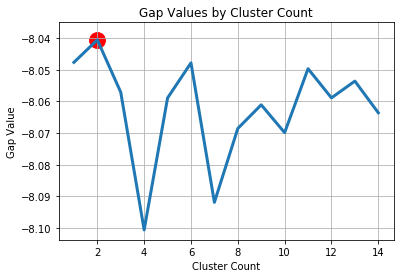

In [119]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [121]:
X

array([[ 6.25403299,  4.14238553],
       [-1.51790146, -7.66446399],
       [-4.51979763, -7.11993667],
       ...,
       [ 6.69642409,  1.22875987],
       [-3.05883241, -7.30460704],
       [ 7.43507273,  0.54901084]])